# Chem 277B Spring 2024 Tutorial 8
---
## Outline
+ Suggestions about using activation function on the final output layer
+ Recurrent Neural Network & LSTM

## Suggestions about using activation functions

In most cases, the output layer is not being activated because the activation function will shrink the output range, which disable the model fit to data out of the range. For example, tanh will give output between -1 and 1, so if the targets range from $(-2, 2)$, the model will fail to learn. 

But if the targets are probabilities, it's better to use Sigmoid or Softmax, which will enforce an output value in $(0,1)$.

## Recurrent Neural Network

RNN is a series of architecutres that is designed for sequential data, such as audio and text.

### Vanilla RNN

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2880px-Recurrent_neural_network_unfold.svg.png" width="800" />

+ Inputs: 
    
    - $\boldsymbol{X}(X_1,X_2,\cdots,X_t)$
    
    - $h_0$
    
+ Feed forward:
    
   $$h_t = \sigma(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})$$
    
    $$y_t = \sigma(h_t W_{oh}^T + b_{oh}) $$
   
+ PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog("rdApp.*")

In [5]:
# nn.RNN(input_dim, hidden_dim, num_layers)
rnn = nn.RNN(5, 3, 1, batch_first=True)

# input shape: (n_batch, n_seq, input_dim)
inputs = torch.rand(1, 2, 5)

# h0 shape: (n_layers, n_batch, hidden_dim)
h0 = torch.rand(1, 1, 3)

# output(h1,...,ht), ht
output, ht = rnn(inputs, h0)

print(output)
print(ht)

tensor([[[-0.3951, -0.1684,  0.9080],
         [-0.3552,  0.7251,  0.9015]]], grad_fn=<TransposeBackward1>)
tensor([[[-0.3552,  0.7251,  0.9015]]], grad_fn=<StackBackward0>)


In [6]:
# without explicitly setting h0
output, ht = rnn(inputs)

print(output)
print(ht)

tensor([[[-0.7617,  0.0862,  0.8792],
         [-0.3344,  0.7487,  0.8857]]], grad_fn=<TransposeBackward1>)
tensor([[[-0.3344,  0.7487,  0.8857]]], grad_fn=<StackBackward0>)


### LSTM: Long-short Term Memory


<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*Mb_L_slY9rjMr8-IADHvwg.png" width="600" />

+ Inputs: 
    
    - $\boldsymbol{X}(X_1,X_2,\cdots,X_t)$
    
    - $h_0$
    
    - $c_0$
    
+ Feed forward:
    
    $$\begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
            c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
            h_t = o_t \odot \tanh(c_t) \\
        \end{array}$$

+ PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
   

In [7]:
lstm = nn.LSTM(5, 3, 1, batch_first=True)

# input shape: (n_batch, n_seq, input_dim)
inputs = torch.rand(1, 2, 5)

# hidden shape: (n_layers, n_batch, hiden_dim)
h0 = torch.rand(1, 1, 3)
c0 = torch.rand(1, 1, 3)

# output: h1, ... ht
# ht, ct
output, (ht, ct) = lstm(inputs, (h0, c0))

print(output)
print(ht)
print(ct)

tensor([[[ 0.1195, -0.1263,  0.1860],
         [ 0.1966, -0.1766,  0.1420]]], grad_fn=<TransposeBackward0>)
tensor([[[ 0.1966, -0.1766,  0.1420]]], grad_fn=<StackBackward0>)
tensor([[[ 0.5438, -0.3659,  0.9040]]], grad_fn=<StackBackward0>)


### SMILES

+ [Reference](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html)
+ [A website for converting structures to SMILES](https://web.chemdoodle.com/demos/smiles#customise-template)
+ [A website for converting SMILES to structures](https://cdb.ics.uci.edu/cgibin/Smi2DepictWeb.py)

SMILES (**S**implified **M**olecular **I**nput **L**ine **E**ntry **S**ystem) is a line notation (a typographical method using printable characters) for entering and representing molecules and reactions.

#### Examples:

+ Methane: C
+ Ethene: C=C
+ Hydrogen cyanide: C#N
+ Neopentane: C(C)(C)(C)C
+ Cyclohexane: C1CCCCC1
+ Benzene: c1ccccc1


#### Basic Rules:

+ Atoms are specified by its symbol with square brakets `[]` except for B, C, N, O, P, S, F, Cl, Br, I when they are normal valenced. **Hydrogens are implicitly represented.**
+ Bonds are specified with "-" (single), "=" (double) or "#" (triple).
+ Branches are specified by enclosing them in parentheses, and can be nested or stacked. 
+ Cyclic structures are represented by breaking one bond in each ring. The bonds are numbered in any order, designating ring opening (or ring closure) bonds by a digit immediately following the atomic symbol at each ring closure.
+ Aromatic systems can be specified with lowercase characters or in Kekule form (in practice the latter may be preferred).
+ ...

### Generate SMILES strings using RNN

Data pre-processing:

+ Add starting/ending tokens

    - `SOS`: Start Of Sequence

    - `EOS`: End Of Sequence

+ One-hot Encoding

+ Padding

In [9]:
def load_smiles(path):
    with open(path) as f:
        smiles = f.read().split('\n')
    return smiles

smiles = load_smiles("ani_smiles_clean.txt")
smiles[:10]

['C', 'N', 'O', 'CC', 'CN', 'N#N', 'NO', 'N=O', 'CO', 'C=C']

Padding: `"C=CC#N" -> ['SOS', 'C', '=', 'C', 'C', '#', 'N', 'EOS']`

In [10]:
def pad_start_end_token(smiles):
    padded = []
    for smi in smiles:
        padded.append(["SOS"] + list(smi) + ["EOS"])
    return padded


padded_smiles = pad_start_end_token(smiles)
padded_smiles[:10]

[['SOS', 'C', 'EOS'],
 ['SOS', 'N', 'EOS'],
 ['SOS', 'O', 'EOS'],
 ['SOS', 'C', 'C', 'EOS'],
 ['SOS', 'C', 'N', 'EOS'],
 ['SOS', 'N', '#', 'N', 'EOS'],
 ['SOS', 'N', 'O', 'EOS'],
 ['SOS', 'N', '=', 'O', 'EOS'],
 ['SOS', 'C', 'O', 'EOS'],
 ['SOS', 'C', '=', 'C', 'EOS']]

In [11]:
# Vocabulary: unique tokens
vocab = np.unique(np.concatenate(padded_smiles))
print(len(vocab))
vocab

17


array(['#', '(', ')', '1', '2', '=', 'C', 'EOS', 'H', 'N', 'O', 'SOS',
       '[', ']', 'c', 'n', 'o'], dtype='<U3')

In [24]:
enc = OneHotEncoder().fit(vocab.reshape(-1, 1))
for i, s in enumerate(padded_smiles):
    print(s)
    print(enc.transform(np.array(s).reshape(-1,1)).toarray())
    if i == 10: break

['SOS', 'C', 'EOS']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['SOS', 'N', 'EOS']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['SOS', 'O', 'EOS']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['SOS', 'C', 'C', 'EOS']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
['SOS', 'C', 'N', 'EOS']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.

In [25]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, vocab):
        
        self.vocab = vocab.reshape(-1, 1)
        
        # One-hot encoding
        self.encoder = OneHotEncoder()
        self.encoder.fit(self.vocab)
        
        self.data = [
            torch.tensor(
                self.encoder.transform(np.array(s).reshape(-1,1)).toarray(), # transform data
                dtype=torch.float
            ) for s in smiles
        ]
        
        # Padding: nn.utils.rnn.pad_sequence
        # shape: (n_samples, n_sequence, n_tokens)
        self.data = nn.utils.rnn.pad_sequence(self.data, batch_first=True)
        
        self.X = self.data[:, :-1, :]
        self.y = self.data[:, 1:, :]
        
    def __len__(self):
        return int(self.data.shape[0])
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

    
data = SmilesDataset(padded_smiles, vocab)
input_size = data.vocab.shape[0] # should be 17
data.data.shape

torch.Size([1771, 17, 17])

### Define Model

In [26]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x, h):
        # rnn
        out, h = self.rnn(x, h)
        # fc
        out = self.fc(out)
        # softmax
        out = self.softmax(out)
        return out, h
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

### Trainer

Training: try to predict the output tokens given inputs. 

For example, a valid SMILES is `['SOS', 'C', 'N', 'EOS']`. Give model `['SOS', 'C', 'N']`, and try to let the model output `['C', 'N', 'EOS']`. In this way, the model can learn some information about probability distribution of the output tokens given inputs.

In [27]:
class Trainer:
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
        
    
    def train(self, train_data, draw_curve=True):
        self.encoder = train_data.encoder
        
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        train_loss_list, train_acc_list = [], []
        
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = y_batch.shape[0] / len(train_data)
                hidden = self.model.init_hidden(y_batch.shape[0])
                
                # batch outputs
                y_pred, _ = self.model(X_batch, hidden)
                
                # loss func
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                # record accuracy
                batch_acc = torch.sum(torch.argmax(y_batch, axis=-1) == torch.argmax(y_pred, axis=-1))
                
                epoch_acc += batch_acc.detach().cpu().item() * batch_importance
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
            
            train_acc_list.append(epoch_acc)
            train_loss_list.append(epoch_loss)
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].set_title("Accuracy")
            axes[1].legend()
    
    def sample(self, num_seq=10):
        self.model.eval()
        seqs = []
        with torch.no_grad():
            for _ in tqdm(range(num_seq), leave=False):
                chars = ['SOS']
                hidden = self.model.init_hidden(1)
                while chars[-1] != 'EOS':
                    input_encoding = self.encoder.transform(np.array([chars[-1]]).reshape(-1, 1)).toarray()
                    input_encoding = torch.tensor(input_encoding, dtype=torch.float).reshape(1, 1, -1)
                    out, hidden = self.model(input_encoding, hidden)

                    prob = out.detach().numpy().flatten()
                    prob /= np.sum(prob)

                    index = np.random.choice(self.model.input_size, p=prob)
                    out_encoding = np.zeros((1, self.model.input_size))
                    out_encoding[0, index] = 1.0
                    char = data.encoder.inverse_transform(out_encoding).flatten().tolist()[0]
                    chars.append(char)
                seqs.append(''.join(chars[1:-1]))
        return seqs


def validate(seq):
    num = len(seq)
    unique = set(seq)
    valid = []
    for s in unique:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            valid.append(s)
            
    print(f"Number of unique SMILES: {len(unique)}")
    print(f"Number of valid & unique SMILES: {len(valid)}")
    return valid

Number of unique SMILES: 15
Number of valid & unique SMILES: 7


['CC1CCC1',
 'C#CC1CC1',
 'CC1CC1C=O',
 'CCC1CC1',
 'C1CC=CC1',
 'C1CCCC1',
 'CNC1CC1']

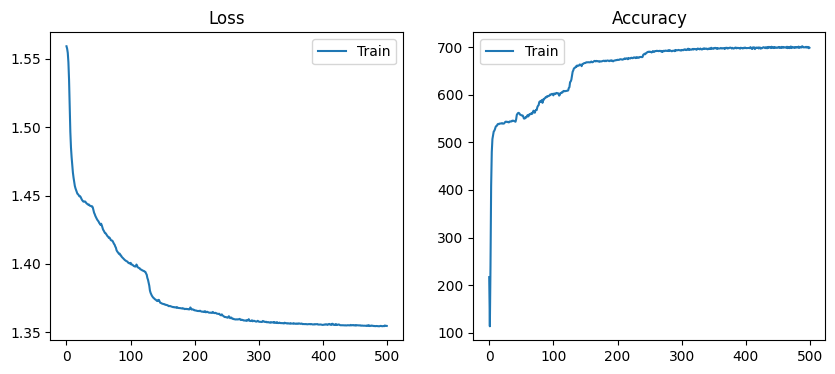

In [28]:
model = VanillaRNN(input_size, 32, 1)
trainer = Trainer(model, "adam", 1e-3, 128, 500, 1e-5)
trainer.train(data)
seqs = trainer.sample(1000)
validate(seqs)